## Plotting for different figures.

In [1]:
# Library imports.
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle, Ellipse, Patch
from scipy.stats import chi2
import numpy as np
import pandas as pd
from pathlib import Path
from scipy import stats
from sklearn.decomposition import PCA

# Urbansurge imports.
from urbansurge import swmm_model
from urbansurge.fault_diagnosis import data_utils, residual_detection

# Autoreload.
%load_ext autoreload
%autoreload 2

In [2]:
# SWMM model configuration file path.
config_path = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\lab_system_config.yml"

# Node where impulse is added.
input_node = 18

# Physical model fault database path.
phy_save_fp = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\diagnosis_pipeline\phy_impulse_fault_database.csv"

# Simulation model fault database path.
sim_save_fp = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\diagnosis_pipeline\sim_impulse_fault_database.csv"

# Physical model with no faults (i.e., "healthy" case)
phy_healthy_save_fp = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\diagnosis_pipeline\phy_healthy_impulse_database.csv"

# Simulation model with no faults (i.e., "healthy" case)
sim_healthy_save_fp = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\diagnosis_pipeline\sim_healthy_impulse_database.csv"

# Figure save path.
fig_savefp = Path(r'C:\Users\ay434\Box\Research\Smart_Stormwater\Fault_Diagnosis_Paper\Manuscript\manuscript-v1\Figures')

In [3]:
# Physical system fault database.
phy_db = pd.read_csv(phy_save_fp)

# Simulation system fault database.
# sim_db = pd.read_csv(phy_save_fp)

# Physical healthy system run.
phy_healthy_db = pd.read_csv(phy_healthy_save_fp)

# Simulated healthy system run.
# sim_healthy_db = pd.read_csv(phy_healthy_save_fp)

In [4]:
# Remove roughness faults.
phy_db = phy_db.loc[phy_db['fault_type']!='roughness', :].reset_index(drop=True)

In [5]:
print(f"Start: {phy_healthy_db['datetime'].iloc[0]}")
print(f"End: {phy_healthy_db['datetime'].iloc[-1]}")


Start: 2020-01-01 00:01:00
End: 2020-01-01 06:00:00


In [7]:
# Create instance of SWMM model.
swmm = swmm_model.SWMM(config_path)

# Configure model.
swmm.configure_model()

Simulation info
Flow Units: CFS
System Units: US
Start Time: 2020-01-01 00:00:00
Start Time: 2020-01-01 06:00:00


### Fault detection plotting

In [9]:
# Hours to clip data.
clip_hours = 6

# Error scale.
noise_scale = 0.2

# Relative noise.
relative_noise = True

if relative_noise is True:
    depth_noise_scale = noise_scale
    velocity_noise_scale = noise_scale
else:
    # Define absolute measurement noise scale as a fraction of the maximum depth in the outfall link reached under the healthy case.
    max_depth = np.max(phy_healthy_db['Depth_link_20'])
    depth_noise_scale = noise_scale * max_depth

    # Scale of velocity noise.
    max_velocity = np.max(phy_healthy_db['Velocity_link_20'])
    velocity_noise_scale = noise_scale * max_velocity

# Sensor columns.
sensor_links = [20]

dep_cols = [f'Depth_link_{s}' for s in sensor_links]
vel_cols = [f'Velocity_link_{s}' for s in sensor_links]
dep_vel_cols = dep_cols + vel_cols

# Clipped data frames.
phy_db_clip = data_utils.clip_timeseries(phy_db, clip_hours)
phy_db_clip = data_utils.clip_timeseries(phy_db, clip_hours)
phy_healthy_db_clip = data_utils.clip_timeseries(phy_healthy_db, clip_hours, by_scenario=False) 
phy_healthy_db_clip = data_utils.clip_timeseries(phy_healthy_db, clip_hours, by_scenario=False) 

# Add noise to physical data.
if relative_noise is True:
    depth_noise = np.random.normal(0, depth_noise_scale * phy_db_clip[dep_cols])
    velocity_noise = np.random.normal(0, velocity_noise_scale * phy_db_clip[vel_cols])
else:
    depth_noise = np.random.normal(0, depth_noise_scale, size=(phy_db_clip[dep_cols].shape))
    velocity_noise = np.random.normal(0, velocity_noise_scale, size=(phy_db_clip[vel_cols].shape))
phy_db_clip[dep_cols] += depth_noise
phy_db_clip[vel_cols] += velocity_noise

# Baseline observations and ensemble from multiple samples.
n_samples = 10 # Number of times the baseline system is sampled.

# Depth baseline observations.
d_obs_baseline, d_baseline_ens_df = data_utils.generate_baseline_observations(phy_healthy_db_clip, dep_cols, 
                                                                            n_samples, depth_noise_scale, relative_noise=relative_noise)
d_obs_baseline = np.moveaxis(d_obs_baseline, 2, 0)
d_obs_baseline[d_obs_baseline < 0] = 0 # Depth cannot be negative.
print('Depth baseline observations shape', d_obs_baseline.shape)

# Velocity baseline observations.
v_obs_baseline, v_baseline_ens_df = data_utils.generate_baseline_observations(phy_healthy_db_clip, vel_cols, 
                                                                            n_samples, velocity_noise_scale, relative_noise=relative_noise)
v_obs_baseline = np.moveaxis(v_obs_baseline, 2, 0)
v_obs_baseline[v_obs_baseline < 0] = 0
print('Velocity baseline observations shape', v_obs_baseline.shape)

# Wetted area for observed baseline.
area_obs_baseline = np.zeros_like(d_obs_baseline)
for id, dep_col in enumerate(dep_cols):
    link_id = dep_col.split('_')[-1]
    area_obs_baseline[:,:,id] = swmm.compute_area_from_depth(d_obs_baseline[:,:,id], link_id)
    
# Compute flow rate Q.
Q_obs_baseline = v_obs_baseline * area_obs_baseline * 0.0283168 # Convert ft^3 to m^3.

# Ensemble baseline flow rate.
Q_baseline_ens = np.mean(np.squeeze(Q_obs_baseline)[1:,:], axis=0) 

# Residual data frames.
# phy_residual_df = data_utils.compute_residuals(phy_db_clip, baseline_ens_df, dep_vel_cols)
phy_residual_df = data_utils.compute_residuals(phy_db_clip, phy_healthy_db_clip, dep_vel_cols)
sim_residual_df = phy_residual_df.copy()

# Normalize residuals.
phy_residual_norm_df = data_utils.normalize_states(swmm, phy_residual_df, sensor_links, norm_type=None)
# sim_residual_norm_df = data_utils.normalize_states(swmm, sim_residual_df, sensor_links, norm_type=None)
phy_norm_df = data_utils.normalize_states(swmm, phy_db_clip, sensor_links, norm_type=None)
# sim_norm_df = data_utils.normalize_states(swmm, sim_db_clip, sensor_links, norm_type=None)

# Reshape state variable arrays into 3D arrays where each slice is a separate scenario.
Xphy_res, yphy_res = data_utils.prepare_states(phy_residual_norm_df, dep_vel_cols)
Xsim_res, ysim_res = Xphy_res, yphy_res
Xphy, yphy = data_utils.prepare_states(phy_norm_df, dep_vel_cols)
Xsim, ysim = Xphy, yphy

# Reshape state variable arrays into 3D arrays where each slice is a separate scenario.
# Xphy, yphy = data_utils.prepare_states(phy_db_clip, dep_vel_cols)
# Xsim, ysim = data_utils.prepare_states(sim_db_clip, dep_vel_cols)
Xphy_dep, yphy = data_utils.prepare_states(phy_db_clip, dep_cols)
Xphy_vel, _ = data_utils.prepare_states(phy_db_clip, vel_cols)
Xphy_dep[Xphy_dep < 0] = 0
Xphy_vel[Xphy_vel < 0] = 0
Xsim_dep, ysim = data_utils.prepare_states(phy_db_clip, dep_cols)
Xsim_vel, _ = data_utils.prepare_states(phy_db_clip, vel_cols)
Xsim_dep[Xsim_dep < 0] = 0
Xsim_vel[Xsim_vel < 0] = 0

# Wetted area for physical sensor observations.
area_phy = np.zeros_like(Xphy_dep)
area_sim = np.zeros_like(Xsim_dep)
for id, dep_col in enumerate(dep_cols):
    link_id = dep_col.split('_')[-1]
    area_phy[:,id,:] = swmm.compute_area_from_depth(np.squeeze(Xphy_dep[:,id,:]), link_id)
    area_sim[:,id,:] = swmm.compute_area_from_depth(np.squeeze(Xsim_dep[:,id,:]), link_id)
    
# Compute flow rate Q.
Qphy = Xphy_vel * area_phy * 0.0283168 # Convert ft^3 to m^3.     
Qsim = Xsim_vel * area_sim * 0.0283168 # Convert ft^3 to m^3. 

# Construct Xsim and Xphy from the depth and velocity components.
Xsim = np.concatenate((Xsim_dep, Xsim_vel), axis=1)
Xphy = np.concatenate((Xphy_dep, Xphy_vel), axis=1)

# 3D array where rows are time steps, columns are depth/velocity sensors, and slices are fault scenarios.
Xsim_g = Xsim.transpose(1, 0, 2).reshape(-1, Xsim.shape[2]).T
print('Xsim_g dims:', Xsim_g.shape)

# Convert fault severity column to numerical values.
ysim_S = np.array(ysim['fault_value'], dtype=np.float32)

# Create tensors to pass into ANN.
Xphy_g = Xphy.transpose(1, 0, 2).reshape(-1, Xphy.shape[2]).T
Xphy_g[Xphy_g < 0] = 0
print('Xphy_g dims:', Xphy_g.shape)

# Convert fault severity column to numerical values.
yphy_S = np.array(yphy['fault_value'], dtype=np.float32)

# Fault class labels.
ysim_C = ysim['fault_type']
yphy_C = yphy['fault_type']


Depth baseline observations shape (10, 360, 1)
Velocity baseline observations shape (10, 360, 1)
Xsim_g dims: (300, 720)
Xphy_g dims: (300, 720)


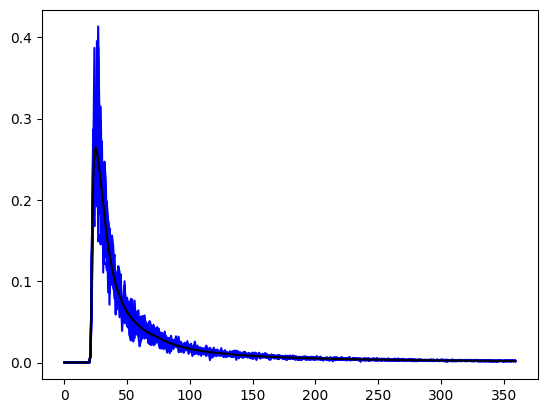

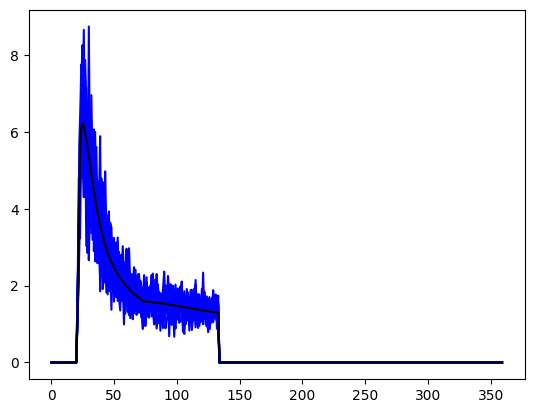

In [13]:
fig, ax = plt.subplots()
for i in range(n_samples):
    ax.plot(np.squeeze(d_obs_baseline[i,:,:]), 'b')
ax.plot(phy_healthy_db_clip['Depth_link_20'], 'k')

fig, ax = plt.subplots()
for i in range(n_samples):
    ax.plot(np.squeeze(v_obs_baseline[i,:,:]), 'b')
ax.plot(phy_healthy_db_clip['Velocity_link_20'], 'k')

[Timestamp('2020-01-01 00:00:00'), Timestamp('2020-01-01 00:01:00'), Timestamp('2020-01-01 00:02:00'), Timestamp('2020-01-01 00:03:00'), Timestamp('2020-01-01 00:04:00'), Timestamp('2020-01-01 00:05:00'), Timestamp('2020-01-01 00:06:00'), Timestamp('2020-01-01 00:07:00'), Timestamp('2020-01-01 00:08:00'), Timestamp('2020-01-01 00:09:00'), Timestamp('2020-01-01 00:10:00'), Timestamp('2020-01-01 00:11:00'), Timestamp('2020-01-01 00:12:00'), Timestamp('2020-01-01 00:13:00'), Timestamp('2020-01-01 00:14:00'), Timestamp('2020-01-01 00:15:00'), Timestamp('2020-01-01 00:16:00'), Timestamp('2020-01-01 00:17:00'), Timestamp('2020-01-01 00:18:00'), Timestamp('2020-01-01 00:19:00'), Timestamp('2020-01-01 00:20:00'), Timestamp('2020-01-01 00:21:00'), Timestamp('2020-01-01 00:22:00'), Timestamp('2020-01-01 00:23:00'), Timestamp('2020-01-01 00:24:00'), Timestamp('2020-01-01 00:25:00'), Timestamp('2020-01-01 00:26:00'), Timestamp('2020-01-01 00:27:00'), Timestamp('2020-01-01 00:28:00'), Timestamp('20

ValueError: x and y must have same first dimension, but have shapes (360,) and (10, 360, 360)

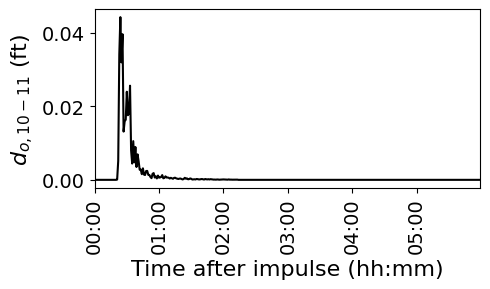

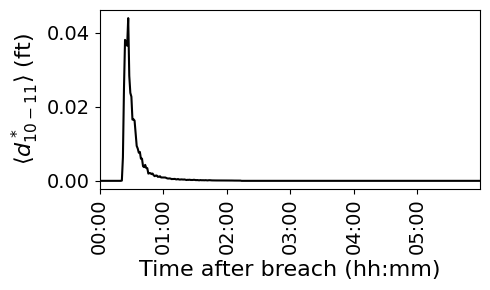

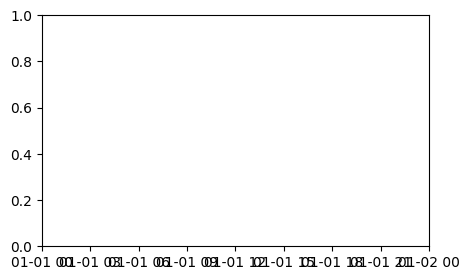

In [14]:
scenario = 250

res_base = Q_obs_baseline - Q_baseline_ens
res_obs = np.squeeze(Qphy[:,:,scenario]) - Q_baseline_ens

# Datetime. 
dt = list(phy_healthy_db.loc[:Xsim.shape[0]-1, 'datetime'] - timedelta(minutes=1))
print(dt)

# Plot individual baseline samples.
# ============================================================
for sample_no in range(n_samples):
    fig, ax = plt.subplots(figsize=(5,3))
    y_base = np.squeeze(Q_obs_baseline[sample_no - 1,:])
    y_base[y_base < 0] = 0
    ax.plot(dt, y_base, 'k')

    # Format x-axis.
    myFmt = mdates.DateFormatter('%H:%M')
    ax.xaxis.set_major_formatter(myFmt)
    plt.setp(ax.get_xticklabels(), rotation=90)
    ax.set_xlim(dt[0], dt[-1])
    ax.set_xlabel('Time after impulse (hh:mm)', fontsize=16)

    # Format yaxis.
    ax.set_ylabel('$d^*_{10-11}$ (ft)', fontsize=16)
    ax.set_ylabel('$d_{o,10-11}$ (ft)', fontsize=16)

    # Format tick labels.
    ax.tick_params(labelsize=14)

    fig.tight_layout()
    fig.savefig(fig_savefp / 'obs_sample_{}.png'.format(sample_no), dpi=300)

    break

# Plot individual baseline ensemble.
# ============================================================
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(dt, Q_baseline_ens, 'k')

# Format x-axis.
myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)
plt.setp(ax.get_xticklabels(), rotation=90)
ax.set_xlim(dt[0], dt[-1])
ax.set_xlabel('Time after breach (hh:mm)', fontsize=16)

# Format yaxis.
ax.set_ylabel('$\\langle d^*_{10-11} \\rangle$ (ft)', fontsize=16)

# Format tick labels.
ax.tick_params(labelsize=14)

fig.tight_layout()
# fig.savefig(fig_savefp / 'baseline_ensemble.png', dpi=300)

# Plot estimate residuals.
# ============================================================
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(dt, res_base, 'k')

# Format x-axis.
myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)
plt.setp(ax.get_xticklabels(), rotation=90)
ax.set_xlim(dt[0], dt[-1])
ax.set_xlabel('Time after breach (hh:mm)', fontsize=16)

# Format yaxis.
ax.set_ylabel('$\epsilon^*_{10-11}$ (ft)', fontsize=16)

# Format tick labels.
ax.tick_params(labelsize=14)
ax.set_ylabel('Count', fontsize=16)
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0

fig.tight_layout()
# fig.savefig(fig_savefp / 'baseline_residuals.png', dpi=300)

# Plot baseline residual histogram.
# ============================================================
fig, ax = plt.subplots(figsize=(5,3))
ax.hist(res_base, bins=21, color='k', alpha=0.5)

# Format x-axis.
ax.set_xlabel('$\epsilon^*_{10-11}$ (ft)', fontsize=16)

# Format yaxis.
ax.set_ylabel('Count', fontsize=16)
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0

# Format tick labels.
ax.tick_params(labelsize=14)

fig.tight_layout()
# fig.savefig(fig_savefp / 'baseline_residuals_hist.png', dpi=300)


### Fault signal plotted against baseline.

0.5510204081632654


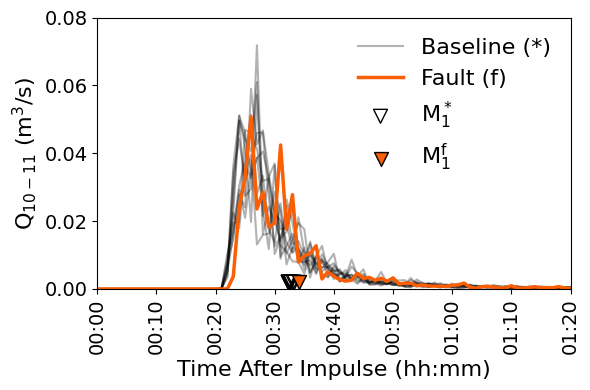

In [15]:
# Fault characteristics.
fault_type = 'diameter'
fault_value_idx = 30
fault_component = 79
fault_values = np.unique(phy_db.loc[(phy_db['fault_type']==fault_type), 'fault_value'])
print(fault_values[fault_value_idx])
scenario = phy_db.loc[(phy_db['fault_type']==fault_type) & (phy_db['fault_component']==fault_component) & (phy_db['fault_value']==fault_values[fault_value_idx]), 'scenario'].iloc[0]
Q_fault = Qphy[:,:,scenario].flatten()
Q_fault_sim = Qsim[:,:,scenario].flatten()

# Datetimes.
datetimes = list(pd.to_datetime(phy_healthy_db['datetime']) - timedelta(minutes=1))

# Compute baseline 1st moments.
# Time steps to hours since first time step.
t = np.array([(datetimes[i] - datetimes[0]).total_seconds() / 3600 for i in range(len(datetimes))])
y_samp = np.squeeze(Q_obs_baseline)
m0_base = np.sum(y_samp, axis=1)
m1_base = np.sum(t * y_samp, axis=1) / m0_base
m1_times = [datetimes[0] + timedelta(hours=m1_base[i]) for i in range(len(m1_base))]

# Compute fault 1st moment.
m0_fault = np.sum(Q_fault)
m1_fault = np.sum(t * Q_fault) / m0_fault
m1_fault_time = datetimes[0] + timedelta(hours=m1_fault)

fig, ax = plt.subplots(figsize=(6,4))
lines = ax.plot(datetimes, np.squeeze(Q_obs_baseline.T), 'k', alpha=0.3)
lines[0].set_label('Baseline (*)')
ax.plot(datetimes, Q_fault, c='#fc5e03', label='Fault (f)', linewidth=2.5)
ax.scatter(m1_times, np.zeros_like(m1_base) + 0.002, marker='v', edgecolors='k', s=100, facecolors="None", label='$\\rm M_1^*$')
ax.scatter(m1_fault_time, 0.002, marker='v', edgecolors='k', s=100, facecolors="#fc5e03", label='$\\rm M_1^f$', zorder=3)

ax.set_xlim([datetimes[0], datetimes[80]])
ax.set_ylim([0, 0.08])
ax.tick_params(axis='both', labelsize=14)
myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)
plt.setp(ax.get_xticklabels(), rotation=90)
ax.legend(fontsize=16, frameon=False)
ax.set_xlabel('Time After Impulse (hh:mm)', fontsize=16)
ax.set_ylabel('$\\rm Q_{10-11} \ (m^3/s)$', fontsize=16)
fig.tight_layout()
# fig.savefig(fig_savefp / 'fault_signal_m1.png', dpi=300)

### Fault diagnosis example

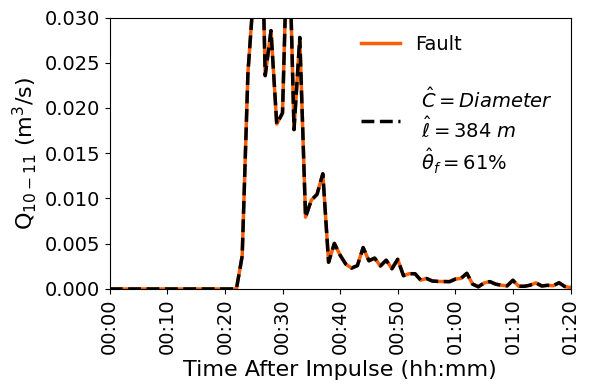

In [16]:
# Simulated fault closest to actual fault.


fig, ax = plt.subplots(figsize=(6,4))
ax.plot(datetimes, Q_fault, c='#fc5e03', label='Fault', linewidth=2.5)
ax.plot(datetimes, Q_fault_sim, 'k--', label='\n $\hat{C}=Diameter$ \n $\hat{\\ell}=384 \ m$ \n $\\hat{\\theta}_f=61 \%$', linewidth=2.5)

ax.set_xlim([datetimes[0], datetimes[80]])
ax.set_ylim([0, 0.03])
ax.tick_params(axis='both', labelsize=14)
myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)
plt.setp(ax.get_xticklabels(), rotation=90)
ax.legend(fontsize=14, frameon=False)
ax.set_xlabel('Time After Impulse (hh:mm)', fontsize=16)
ax.set_ylabel('$\\rm Q_{10-11} \ (m^3/s)$', fontsize=16)
fig.tight_layout()
fig.savefig(fig_savefp / 'fault_diagnosis_eg.png', dpi=300)

### Faults that cause flooding at the 2-yr storm level.

In [13]:
# Load in databases.
dir_fp = Path(r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\diagnosis_pipeline")

phy_2y_df = pd.read_csv(dir_fp / 'phy_impulse_2.5yr_fault_database.csv')
sim_2y_df = pd.read_csv(dir_fp / 'sim_impulse_2.5yr_fault_database.csv')
phy_healthy_2y_df = pd.read_csv(dir_fp / 'phy_healthy_impulse_2.5yr_database.csv')
sim_healthy_2y_df = pd.read_csv(dir_fp / 'sim_healthy_impulse_2.5yr_database.csv')

In [76]:
# Maximum severity for each fault class.
class_severity_dict = {
    'diameter': 0,
    'roughness': 0,
    'silting': 0
}
for fault_class in class_severity_dict.keys():
    class_severity_dict[fault_class] = np.max(phy_2y_df.loc[phy_2y_df['fault_type']==fault_class, 'fault_value'])

# Compute flooding for each scenario.
sceanrios = np.unique(phy_2y_df['scenario'])
cumu_flood = np.zeros(len(scenarios))
flooding_cols = [col for col in phy_2y_df.columns if 'Flood' in col]
fault_classes = []
fault_components = []
fault_severities = []
for scenario in sceanrios:
    flooding = phy_2y_df.loc[phy_2y_df['scenario']==scenario, flooding_cols].to_numpy()
    cumu_flood[scenario] = np.sum(flooding)

    # Fault type, location, and severity.
    fault_class = phy_2y_df.loc[phy_2y_df['scenario']==scenario, 'fault_type'].iloc[0]
    fault_severity = phy_2y_df.loc[phy_2y_df['scenario']==scenario, 'fault_value'].iloc[0]
    fault_classes.append(fault_class)
    fault_component = phy_2y_df.loc[phy_2y_df['scenario']==scenario, 'fault_component'].iloc[0]
    fault_components.append(fault_component)    
    fault_severities.append(fault_severity / class_severity_dict[fault_class])

# Indices of critical faults.
critical_fault_idx = np.where(cumu_flood > 0)[0]

[ 28  29  30  31  32  33  34  35  36  37  38  39  56  57  58  59  60  61
  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 140 141 142 143 144 145 146 147 148 149 150 151
 152 153 154 155 156 157 158 159 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199 214 215 216 217 218 219 220 221
 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239
 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273
 274 275 276 277 278 279 295 296 297 298 299 300 301 302 303 304 305 306
 307 308 309 310 311 312 313 314 315 316 317 318 319 337 339 340 341 342
 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 424
 425 427 429 430 436 437 438 439 474 475 476 477 478 479 507 509 510 515
 516 517 518 519]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

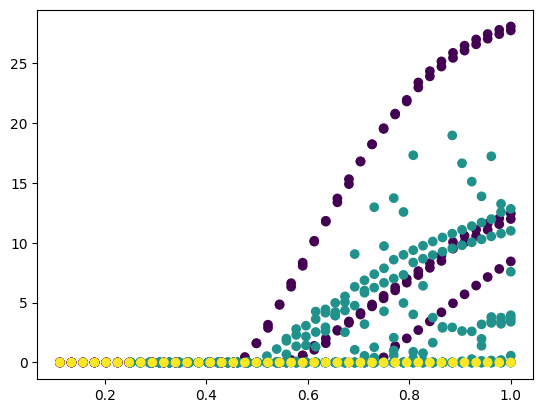

In [71]:
fault_class_category, fault_class_unique = pd.factorize(fault_classes)
print(fault_class_category)
print(fault_class_unique)

fig, ax = plt.subplots()
ax.scatter(fault_severities, cumu_flood, c=fault_class_category)

### Moment Detection

In [21]:
def make_error_boxes(ax, x, y, xerror, yerror, facecolor='r', edgecolor='none', alpha=0.5, draw_ebars=True, label=None):

    # Loop over data points; create box from errors at each point
    errorboxes = [Rectangle((x - xerror[0], y - yerror[0]), xerror.sum(), yerror.sum())]

    # Create patch collection with specified colour/alpha
    pc = PatchCollection(errorboxes, facecolor=facecolor, alpha=alpha,
                         edgecolor=edgecolor)

    # Add collection to Axes
    ax.add_collection(pc)

    # Plot errorbars
    if draw_ebars is True:
        artists = ax.errorbar(x, y, xerr=xerror, yerr=yerror,
                            fmt='none', ecolor='k')

    # Add a legend entry for the error boxes
    if label is not None:
        legend_patch = Patch(color=facecolor, alpha=alpha, label=label)

        return legend_patch
        

# Function to plot the confidence ellipse
def plot_ellipse(ax, mean, cov, p, **kwargs):
    # Calculate the chi-squared value for the given probability p
    chi2_val = chi2.ppf(p, df=2)
    
    # Eigen decomposition to get the orientation and lengths of the ellipse axes
    eigvals, eigvecs = np.linalg.eigh(cov)
    
    # Calculate width and height of the ellipse
    width, height = 2 * np.sqrt(chi2_val * eigvals)
    
    # Get the angle of rotation for the ellipse
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    
    # Create and add the ellipse to the plot
    ellipse = Ellipse(mean, width, height, angle, **kwargs)
    ax.add_patch(ellipse)

C:\Users\ay434\AppData\Local\Temp\ipykernel_784\3743787911.py:63: RuntimeWarning: invalid value encountered in scalar divide
  m1[i] = np.sum(t * y_obs) / np.sum(y_obs)
C:\Users\ay434\AppData\Local\Temp\ipykernel_784\3743787911.py:68: RuntimeWarning: invalid value encountered in scalar divide
  m_obs[i,1] = np.sum(t * y_obs) / np.sum(y_obs)


(360, 1, 300)


C:\Users\ay434\AppData\Local\Temp\ipykernel_784\3743787911.py:110: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], c=cmap(cmap_norm(np.max(sevs))), marker=class_markers[fc], label=class_names[fc])


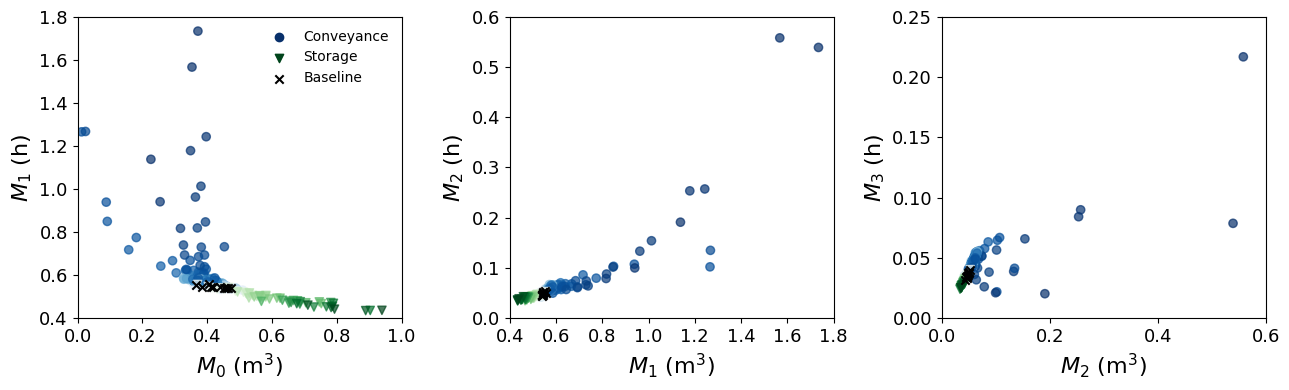

In [48]:
ps = []
sevs = []

# Time.
t = np.array([(dt[i] - dt[0]).total_seconds() / 3600 for i in range(len(dt))])

# Max fraction.
max_frac = 0.05

# Compute moments for baseline scenarios.
m0_base = np.zeros(Q_obs_baseline.shape[0])
m1_base = np.zeros_like(m0_base)
m2_base = np.zeros_like(m0_base)
m3_base = np.zeros_like(m0_base)
m_base = np.zeros((Q_obs_baseline.shape[0], 4))
for i in range(Q_obs_baseline.shape[0]):
    y_base = np.squeeze(Q_obs_baseline[i,:,:])

    # # Clip to where flow drops to X% of max.
    # y_max = np.max(y_base)
    # max_idx = np.argmax(y_base)
    # y_frac = y_base / y_max
    # prc_idx = np.where(y_frac[max_idx:] < max_frac)[0][0]
    # y_base = y_base[:max_idx + prc_idx]
    # t = times[:max_idx + prc_idx]

    # Compute moments.
    m0_base[i] = np.sum(y_base)
    m1_base[i] = np.sum(t * y_base) / np.sum(y_base)
    m2_base[i] = np.sum((t - m1_base[i])**2 * y_base) / np.sum(y_base)
    m3_base[i] = np.sum((t - m1_base[i])**3 * y_base) / np.sum(y_base)

    m_base[i,0] = np.sum(y_base)
    m_base[i,1] = np.sum(t * y_base) / np.sum(y_base)
    m_base[i,2] = np.sum((t - m_base[i,1])**2 * y_base) / np.sum(y_base)
    m_base[i,3] = np.sum((t - m_base[i,1])**3 * y_base) / np.sum(y_base)

# Compute moments for fault scenarios.
scenarios = np.unique(phy_db['scenario'])
m0 = np.zeros(len(scenarios))
m1 = np.zeros(len(scenarios))
m2 = np.zeros(len(scenarios))
m3 = np.zeros(len(scenarios))
m_obs = np.zeros((len(scenarios), 4))
fault_class = []
for i, scenario in enumerate(scenarios):
    y_obs = np.squeeze(Qphy[:,:,i])
    y_obs[y_obs < 0] = 0

    # # Clip to where flow drops to X% of max.
    # y_max = np.max(y_obs)
    # max_idx = np.argmax(y_obs)
    # y_frac = y_obs / y_max
    # prc_idx = np.where(y_frac[max_idx:] < max_frac)[0][0]
    # y_obs = y_obs[:max_idx + prc_idx]
    # t = times[:max_idx + prc_idx]

    # Fault severity.
    sev = phy_db.loc[phy_db['scenario'] == scenario, 'fault_value'].iloc[0]
    sevs.append(sev)

    m0[i] = np.sum(y_obs)
    m1[i] = np.sum(t * y_obs) / np.sum(y_obs)
    m2[i] = np.sum((t - m1[i])**2 * y_obs) / np.sum(y_obs)
    m3[i] = np.sum((t - m1[i])**3 * y_obs) / np.sum(y_obs)

    m_obs[i,0] = np.sum(y_obs)
    m_obs[i,1] = np.sum(t * y_obs) / np.sum(y_obs)
    m_obs[i,2] = np.sum((t - m_obs[i,1])**2 * y_obs) / np.sum(y_obs)
    m_obs[i,3] = np.sum((t - m_obs[i,1])**3 * y_obs) / np.sum(y_obs)

    # Add fault class.
    fault_class.append(phy_db.loc[phy_db['scenario']==scenario, 'fault_type'].iloc[0])

fault_class = np.array(fault_class)

# print('Number of observed exceedances:', n_obs_exceed)
# print('P-value: {:.3f}'.format(p_value))

class_colors = {'diameter': 'blue', 'roughness': 'red', 'silting': 'green'}
class_markers = {'diameter': 'o', 'roughness': '^', 'silting': 'v'}
class_cmaps = {'diameter': 'Blues', 'roughness': 'Reds', 'silting': 'Greens'}
class_names = {'diameter': 'Conveyance', 'silting': 'Storage'}

# Severity-color dictionary.
sev_cmap = {}
sev_norm = {}
for fc in np.unique(fault_class):
    severities = np.sort(np.unique(phy_db.loc[phy_db['fault_type']==fc, 'fault_value']))
    norm = plt.Normalize(vmin=severities.min(), vmax=severities.max())
    cmap = plt.get_cmap(class_cmaps[fc])
    colors = cmap(norm(severities))
    sev_norm[fc] = norm
    sev_cmap[fc] = cmap


print(Qphy.shape)


fig, axes = plt.subplots(1, 3, figsize=(13,4))
for i, ax in enumerate(axes):
    # M_i vs. M_i+1.
    for fc in np.unique(fault_class):
        cmap = sev_cmap[fc]
        cmap_norm = sev_norm[fc]
        sevs = np.array(sevs)
        ax.scatter(m_obs[fault_class==fc, i], m_obs[fault_class==fc, i+1], c=cmap(cmap_norm(sevs[fault_class==fc])), alpha=0.7, marker=class_markers[fc])

        # For legend.
        ax.scatter([], [], c=cmap(cmap_norm(np.max(sevs))), marker=class_markers[fc], label=class_names[fc])

    # Plot baseline samples.
    ax.scatter(m_base[:,i], m_base[:,i+1], color='k', marker='x', label='Baseline')

    # Fit a 2D multivariate normal distribution
    xe = np.mean(m_base[:,i])
    ye = np.mean(m_base[:,i+1])
    # mean = [xe, ye]
    # covariance = np.cov(m0_base, m1_base)
    # plot_ellipse(axes[0], mean, covariance, p=0.95, edgecolor='k', facecolor=[0, 0, 0, 0.25], linewidth=1, label='95% Confidence')

    # Error boxes.
    xerr_H = np.max(m_base[:,i]) - xe
    xerr_L = xe - np.min(m_base[:,i])
    # xerr_H = xerr_L = np.ptp(m_base[:,i])
    yerr_H = yerr_L = np.ptp(m_base[:,i+1])
    xerr = np.array([[xerr_L], [xerr_H]])
    yerr = np.array([[yerr_L], [yerr_H]])
    # ax.errorbar(xe, ye, xerr=xerr, yerr=yerr, fmt='none', ecolor='k')
    # make_error_boxes(ax, xe, ye, xerr, yerr, facecolor='k', edgecolor='none', alpha=0.25, draw_ebars=False, label='$3\sigma$')

    # ax.set_xlim(xe - 2 * xerr_H, xe + 2 * xerr_H)
    # ax.set_ylim(ye - 2 * yerr_H, ye + 2 * yerr_H)

    # Axes formatting
    ax.set_xlabel(f'$M_{i}' + '\ \\rm{(m^3)}$', fontsize=16)
    ax.set_ylabel(f'$M_{i+1}' +  '\ \\rm{(h)}$', fontsize=16)
    ax.tick_params(axis='both', labelsize=13)

# Format tick labels.
axes[0].set_xticks(np.arange(0, 1.2, 0.2))
axes[0].set_yticks(np.arange(0.4, 2, 0.2))
axes[0].set_xlim(0, 1)
axes[0].set_ylim(0.4, 1.8)

axes[1].set_xticks(np.arange(0.4, 2, 0.2))
# axes[1].set_yticks(np.arange(0.4, 2, 0.2))
axes[1].set_xlim(0.4, 1.8)
axes[1].set_ylim(0, 0.6)

# axes[0].set_xticks(np.arange(0, 1.2, 0.2))
# axes[2].set_yticks(np.arange(0.4, 2, 0.2))
axes[2].set_xlim(0, 0.6)
axes[2].set_ylim(0, .25)

# Legend on first plot.
axes[0].legend(frameon=False, loc='upper right')

fig.tight_layout()
fig.savefig(fig_savefp / 'moment_fault_detection.png', dpi=300)

In [125]:
std_m0 = np.std(m_base[:,0])
range_m0 = np.max(m_base[:,0]) - np.min(m_base[:,0])
print(std_m0)
print(range_m0)

0.032028924646632415
0.10696609153984954


### Moments of critical faults

In [26]:
# Select moments with critical fault indices.
m_crit = m_obs[critical_fault_idx, :]
print(m_base)

fig, axes = plt.subplots(1, 3, figsize=(11,3))
for i, ax in enumerate(axes):
    ax.scatter(m_crit[:,i], m_crit[:,i+1], c='r')
    ax.scatter(m_base[:,i], m_base[:,i+1], c='k')

    m_base_max_i = np.max(m_base[:,i])
    m_base_min_i = np.min(m_base[:,i])
    m_base_range_i = m_base_max_i - m_base_min_i
    m_base_max_ip1 = np.max(m_base[:,i+1])
    m_base_min_ip1 = np.min(m_base[:,i+1])
    m_base_range_ip1 = m_base_max_ip1 - m_base_min_ip1
    ax.set_xlim(m_base_min_i - m_base_range_i, m_base_max_i + m_base_range_i)
    ax.set_ylim(m_base_min_ip1 - m_base_range_ip1, m_base_max_ip1 + m_base_range_ip1)

fig.tight_layout()

NameError: name 'critical_fault_idx' is not defined

### Moment ratios

In [126]:
# Distance upstream to each component.
distance_dict = {
    'fault_type': [],
    'fault_component': [],
    'upstream_distance': []
}

# Fault component types.
fault_type_component = {'diameter': 'Link', 'roughness': 'Link', 'silting': 'Junction'}

# Loop through fault components and populate the dictionary.
type_component_df = phy_db[['fault_type', 'fault_component']].drop_duplicates()
type_component_df.reset_index(inplace=True, drop=True)
for i in range(type_component_df.shape[0]):
    component_class = type_component_df.loc[i, 'fault_type']
    component = type_component_df.loc[i, 'fault_component']
    up_dist = swmm.upstream_distance(20, 'Link', component, fault_type_component[component_class])
    distance_dict['fault_type'].append(component_class)
    distance_dict['fault_component'].append(component)
    distance_dict['upstream_distance'].append(up_dist)

# Create data frame from distance dictionary.
distance_df = pd.DataFrame(distance_dict)

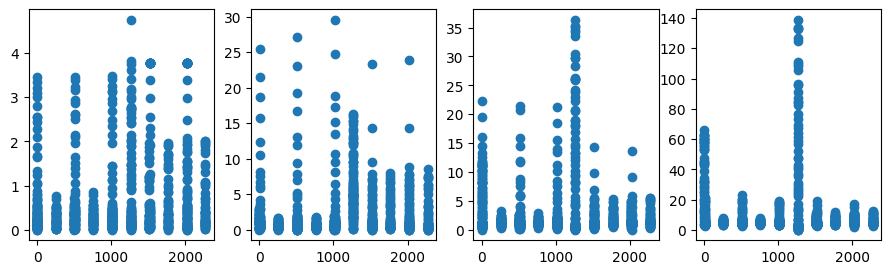

In [127]:
# Moment ratios.
Rm = np.zeros((len(scenarios), 4))
fault_location = np.zeros(len(scenarios))
for scenario in scenarios:
    Rm[scenario, 0] = np.abs(m0[scenario] - np.mean(m0_base)) / (np.max(m0_base) - np.min(m0_base))
    Rm[scenario, 1] = np.abs(m1[scenario] - np.mean(m1_base)) / (np.max(m1_base) - np.min(m1_base))
    Rm[scenario, 2] = np.abs(m2[scenario] - np.mean(m2_base)) / (np.max(m2_base) - np.min(m2_base))
    Rm[scenario, 3] = np.abs(m3[scenario] - np.mean(m3_base)) / (np.max(m3_base) - np.min(m3_base))

    fault_component = phy_db.loc[phy_db['scenario']==scenario, 'fault_component'].iloc[0]
    fault_location[scenario] = distance_df.loc[(distance_df['fault_type']==fault_class[scenario]) & (distance_df['fault_component']==fault_component), 'upstream_distance'].iloc[0]


fig, axes = plt.subplots(1, 4, figsize=(11,3))
for i, ax in enumerate(axes):
    ax.scatter(fault_location, Rm[:, i])


### Plot the fault hydrographs against the healthy hydrograph

C:\Users\ay434\AppData\Local\Temp\ipykernel_18320\2166020978.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_diameter = cm.get_cmap('Blues')
C:\Users\ay434\AppData\Local\Temp\ipykernel_18320\2166020978.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_roughness = cm.get_cmap('Reds')
C:\Users\ay434\AppData\Local\Temp\ipykernel_18320\2166020978.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_silting = cm.get_cmap('Greens')


NameError: name 'sim_db_clip' is not defined

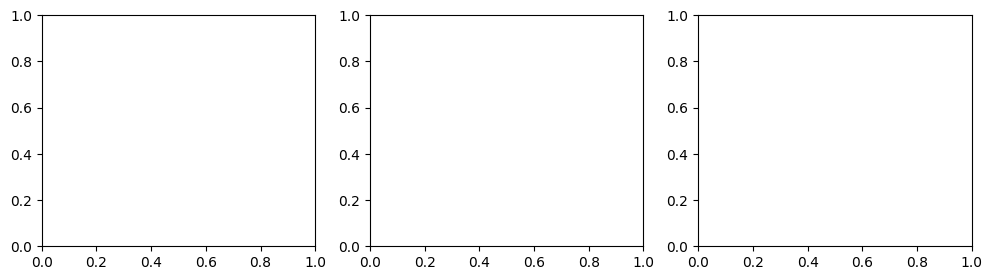

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,3))

# Define the color maps for each fault type
cmap_diameter = cm.get_cmap('Blues')
cmap_roughness = cm.get_cmap('Reds')
cmap_silting = cm.get_cmap('Greens')

# Normalize fault_value for color mapping.
norm_dict = {}
for fault_type in np.unique(sim_db_clip['fault_type']):
    fault_values = np.unique(sim_db_clip.loc[sim_db_clip['fault_type']==fault_type, 'fault_value'].values)
    norm = plt.Normalize(vmin=np.min(fault_values), vmax=np.max(fault_values))
    norm_dict[fault_type] = norm

# Datetime.
dt = list(phy_healthy_db.loc[:Xsim.shape[0]-1, 'datetime'] - timedelta(minutes=1))

# Loop through scenarios and plot.
for scenario in scenarios:
    y_obs = sim_db_clip.loc[sim_db_clip['scenario']==scenario, 'Depth_link_20']
    y_obs = np.squeeze(Qsim[:,:,scenario])
    fault_type = sim_db_clip.loc[sim_db_clip['scenario']==scenario, 'fault_type'].iloc[0]
    fault_value = sim_db_clip.loc[sim_db_clip['scenario']==scenario, 'fault_value'].iloc[0]
    fault_component = sim_db_clip.loc[sim_db_clip['scenario']==scenario, 'fault_component'].iloc[0] 

    if fault_type == 'diameter' and fault_component == 79:
        norm = norm_dict[fault_type]
        color = cmap_diameter(norm(fault_value))
        d_lines = ax1.plot(dt, y_obs, c=color)
    elif fault_type == 'roughness' and fault_component == 43:
        norm = norm_dict[fault_type]
        color = cmap_roughness(norm(fault_value))
        r_lines = ax2.plot(dt, y_obs, c=color)
    elif fault_type == 'silting':
        norm = norm_dict[fault_type]
        color = cmap_silting(norm(fault_value))
        s_lines = ax3.plot(dt, y_obs, c=color)

d_lines[0].set_label('Node 6 Fault')
r_lines[0].set_label('Link 6-7 Fault')
s_lines[0].set_label('Node 5 Fault')

# Formatting accomplished in a loop.
for ax in [ax1, ax2, ax3]:

    ax.set_xlim([datetimes[0], datetimes[80]])
    # ax.set_ylim([0, 0.08])
    # ax.tick_params(axis='both', labelsize=14)
    # myFmt = mdates.DateFormatter('%H:%M')
    # ax.xaxis.set_major_formatter(myFmt)
    # plt.setp(ax.get_xticklabels(), rotation=90)
    # ax.legend(fontsize=16, frameon=False)
    # ax.set_xlabel('Time After Impulse (hh:mm)', fontsize=16)
    # ax.set_ylabel('$\\rm Q_{10-11} \ (m^3/s)$', fontsize=16)

    # Plot baseline.
    ax.plot(dt, sim_healthy_db['Flow_link_20'] * 0.0283168, 'k:', label='Fault-Free')

    # Format datetime x-axis
    myFmt = mdates.DateFormatter('%H:%M')
    ax.xaxis.set_major_formatter(myFmt)
    plt.setp(ax.get_xticklabels(), rotation=90)
    # ax.set_xlim(dt[0], dt[-1])
    ax.set_xlabel('Time after breach (hh:mm)', fontsize=15)

    # Y-axis.
    ax.set_ylabel('$\\rm Q_{10-11} \ (m^3/s)$', fontsize=15)

    # Tick labels.
    ax.tick_params(axis='both', labelsize=13)

    # Legend.
    ax.legend(fontsize=11, frameon=False)

fig.tight_layout()
fig.savefig(fig_savefp / 'AGU24_fault_severity_examples.png', dpi=300)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


diameter 78 0.753061224489796


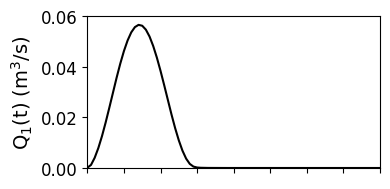

In [10]:
# Depth baseline observations.
d_baseline = phy_healthy_db['Depth_link_20']

# Velocity baseline observations.
v_baseline = phy_healthy_db['Velocity_link_20']

# Wetted area for observed baseline.
area_baseline = swmm.compute_area_from_depth(d_baseline, 20)
    
# Compute flow rate Q.
Q_baseline = v_baseline * area_baseline * 0.0283168 # Convert ft^3 to m^3.

# Datetimes.
datetimes = pd.to_datetime(phy_healthy_db['datetime']) - timedelta(minutes=1)

scenario = 141
fault_type = phy_db_clip.loc[phy_db_clip['scenario']==scenario, 'fault_type'].iloc[0]
fault_component = phy_db_clip.loc[phy_db_clip['scenario']==scenario, 'fault_component'].iloc[0]
fault_value = phy_db_clip.loc[phy_db_clip['scenario']==scenario, 'fault_value'].iloc[0]
print(fault_type, fault_component, fault_value)

fig, ax = plt.subplots(figsize=(4,2))
ax.plot(datetimes, phy_healthy_db['Flow_link_39'] * 0.0283168, 'k')
# ax.plot(datetimes, Qsim[:,:,scenario], 'r', label='Fault')
# ax.set_xlabel('Time After Impulse (hh:mm)', fontsize=14)
ax.set_ylabel('$\\rm Q_1(t) \ \\rm (m^3/s)$', fontsize=14)
# ax.set_ylabel('$Q_{\\rm{impulse}}(t) \ \\rm (cfs)$', fontsize=16)
ax.tick_params(axis='both', labelsize=12)
ax.set_xticklabels([])
# myFmt = mdates.DateFormatter('%H:%M')
# ax.xaxis.set_major_formatter(myFmt)
# plt.setp(ax.get_xticklabels(), rotation=90)
ax.set_xlim([datetimes[0], datetimes[80]])
ax.set_ylim([0, 0.06])
ax.legend(fontsize=16, frameon=False)
fig.tight_layout()

# fig.savefig(fig_savefp / 'impulse.png', dpi=300)


### Plot the baseline impulses

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


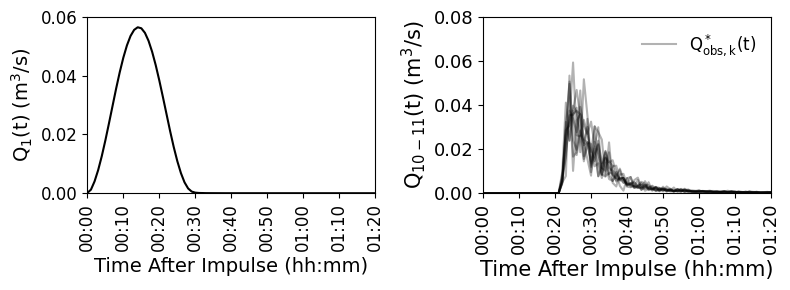

In [13]:
fig, (ax1, ax) = plt.subplots(1, 2, figsize=(8,3))
ax1.plot(datetimes, phy_healthy_db['Flow_link_39'] * 0.0283168, 'k')
ax1.set_xlabel('Time After Impulse (hh:mm)', fontsize=14)
ax1.set_ylabel('$\\rm Q_1(t) \ \\rm (m^3/s)$', fontsize=14)
ax1.tick_params(axis='both', labelsize=12)
ax1.set_xticklabels([])
myFmt = mdates.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(myFmt)
plt.setp(ax1.get_xticklabels(), rotation=90)
ax1.set_xlim([datetimes[0], datetimes[80]])
ax1.set_ylim([0, 0.06])
ax1.legend(fontsize=16, frameon=False)

dt = list(phy_healthy_db.loc[:Xsim.shape[0]-1, 'datetime'] - timedelta(minutes=1))

for i in range(d_obs_baseline.shape[0]):
    lines = ax.plot(dt, np.squeeze(Q_obs_baseline[i,:,:]), alpha=0.3, c='k')

lines[0].set_label('$\\rm Q_{obs, k}^*(t)$')

# ax.plot(dt, Q_baseline_ens, 'r', label='$\\rm \\langle Q_{obs, i}^*(t) \\rangle$')

# Format datetime x-axis
myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)
plt.setp(ax.get_xticklabels(), rotation=90)
ax.set_xlim([datetimes[0], datetimes[80]])
ax.set_xlabel('Time After Impulse (hh:mm)', fontsize=15)

# Y-axis.
ax.set_ylabel('$\\rm Q_{10-11} (t) \ (m^3/s)$', fontsize=15)
ax.set_ylim([0, 0.08])

# Tick labels.
ax.tick_params(axis='both', labelsize=13)
ax.legend(frameon=False, fontsize=12)

fig.tight_layout()
fig.savefig(fig_savefp / 'baseline_impulse_response.png', dpi=300)


### Plot total flooding vs. severity for each fault type.

In [129]:
# Fault types.
fault_types = np.unique(sim_db.fault_type)

# # Severity density arrays for storing diagnosis accuracy metrics.
# severity_density_arrays = {}
severity_dict = {}
flood_dict = {}
for fault_type in fault_types:
    # Severity levels.
    severity_levels = np.unique(sim_db.loc[sim_db.fault_type==fault_type, 'fault_value'])
    severity_dict[fault_type] = severity_levels

    # Add array to flood dict.
    flood_dict[fault_type] = np.zeros_like(severity_levels)

# Scenarios.
scenarios = np.unique(sim_db.scenario)

# for i, scenario in scenarios:
#     # Fault severity.

## Parameter identifiability 

In [133]:

def central_diff(x, y):
    "Central 1st order difference with ghost points."

    N = len(y)
    dx = x[1] - x[0]

    d = np.zeros_like(y)

    # Boundary conditions.
    # Left BC uses a ghost point equal to y[0].
    d[0] = (y[1] - y[0]) / (2 * dx)
    # Right BC uses a ghost point equal to y[-1].
    d[-1] = (y[-1] - y[-2]) / (2 * dx)

    # Loop through remaining points.
    for i in range(1, N - 1):
        d[i] = (y[i+1] - y[i-1]) / (2 * dx)

    return d

### Baseline sample RMSE range.

In [ ]:
# The range in RMSE between baseline samples determines what constitutes a significant sensitivity.
# Sensitivity values within the baseline range are not distinguishable from a healthy system response.


### Sensitivity analysis

Fault Value = 0.0
    fault_component fault_type
0                76   diameter
1                77   diameter
2                78   diameter
3                79   diameter
4                80   diameter
5                39  roughness
6                40  roughness
7                41  roughness
8                42  roughness
9                43  roughness
10               44  roughness
11               45  roughness
12               23  roughness
13               21  roughness
14               20  roughness
15               20    silting


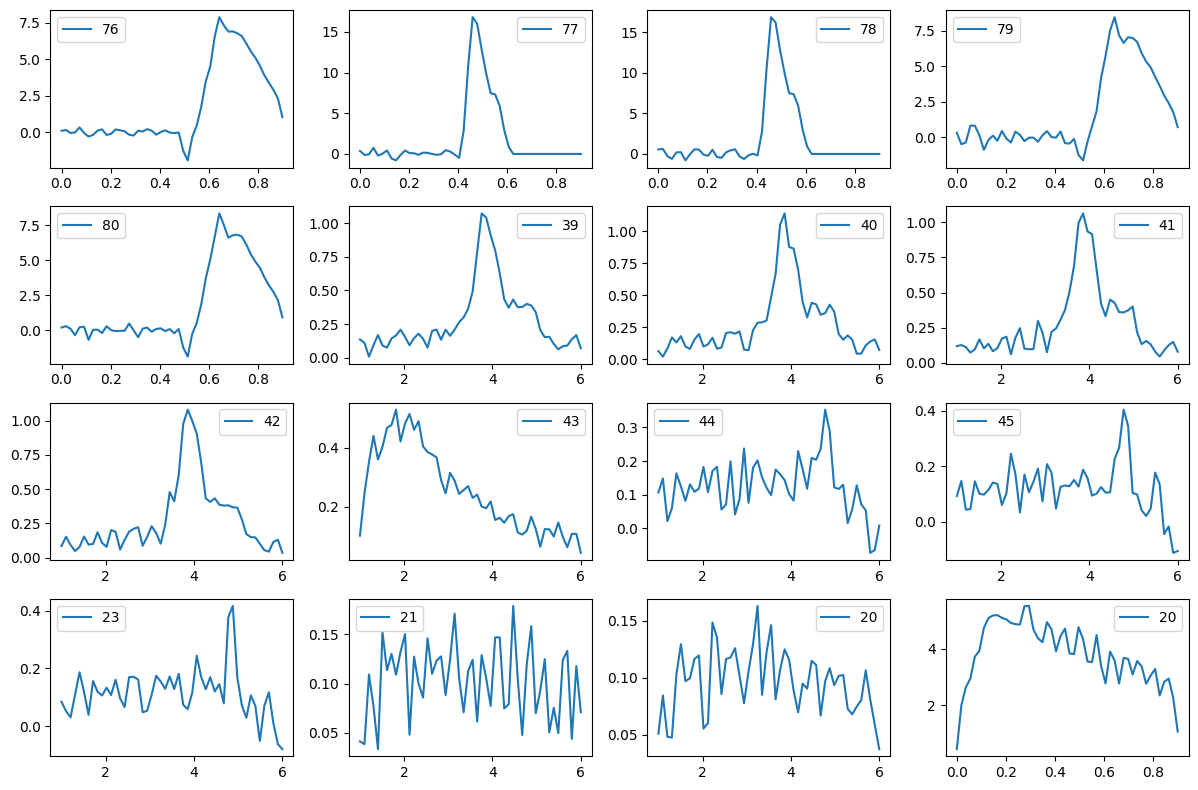

In [134]:
# Select a fault scenario to serve as the observed example. 
fault_component = 20
fault_value_idx = 0
fault_type = 'silting'
fault_values = np.unique(sim_db.loc[(sim_db['fault_component']==fault_component) & (sim_db['fault_type']==fault_type), 'fault_value'])
scenario = sim_db.loc[(sim_db['fault_component']==fault_component) & (sim_db['fault_value']==fault_values[fault_value_idx]) & (sim_db['fault_type']==fault_type), 'scenario'].iloc[0]
print(f'Fault Value = {fault_values[fault_value_idx]}')

# Observation link.
link_id = 20

# Extract time series.
d_obs = sim_db.loc[sim_db['scenario']==scenario, f'Depth_link_{link_id}'].to_numpy()
d_obs += np.random.normal(0, 0.05, size=y_obs.shape)

# Extract velocity time series.
v_obs = sim_db.loc[sim_db['scenario']==scenario, f'Velocity_link_{link_id}'].to_numpy()
v_obs += np.random.normal(0, 0.05, size=y_obs.shape)

# Area of pipe.
area_obs = swmm.compute_area_from_depth(d_obs, link_id)

# Compute flow rate.
Q_obs = v_obs * area_obs

# Compute euclidean distance between this time series and all other time series.
d = np.zeros(len(scenarios))
for i, scenario in enumerate(scenarios):
    d_test = sim_db.loc[sim_db['scenario']==scenario, f'Depth_link_{link_id}'].to_numpy()
    v_test = sim_db.loc[sim_db['scenario']==scenario, f'Velocity_link_{link_id}'].to_numpy()
    area_test = swmm.compute_area_from_depth(d_test, link_id)
    Q_test = v_test * area_test
    d[i] = np.sqrt(np.sum(np.square(Q_test - Q_obs)))

# Number of locations.
unique_components = sim_db[['fault_component', 'fault_type']].drop_duplicates().reset_index(drop=True)
print(unique_components)

# Sensivity.
fig, axes = plt.subplots(4, 4, figsize=(12,8))
axes = axes.flatten()
dist_max = np.zeros(len(unique_components)) # Maximum value from distribution.
dist_hess = np.zeros(len(unique_components)) # Second derivative at maximum.
dist_ar = np.zeros((len(unique_components), 50))
for i in range(unique_components.shape[0]):
    # Extract component and type. 
    component = unique_components.loc[i, 'fault_component']
    fault_type = unique_components.loc[i, 'fault_type']

    # Get scenario IDs for each component.
    scenario_ids = np.unique(sim_db.loc[(sim_db['fault_component']==component) & (sim_db['fault_type']==fault_type), ['scenario', 'fault_value']], axis=0)
    scenario_ids = scenario_ids[scenario_ids[:,1].argsort()] 
    dists = d[scenario_ids[:,0].flatten().astype(int)]
    dist_ar[i,:] = dists
    # dists /= np.sum(dists)

    # Maximum value.
    dist_max[i] = np.max(dists)

    # 2nd derivative at maximum.
    dist_argmax = np.argmax(dists)
    if dist_argmax == 0:
        H = dists[0] - 2 * dists[0] + dists[1] # Ghost point equal to left edge.
    elif dist_argmax == len(dists) - 1:
        H = dists[-2] - 2 * dists[-1] + dists[-1] # Ghost point equal to right edge.
    else:
        H = dists[dist_argmax - 1] - 2 * dists[dist_argmax] + dists[dist_argmax + 1]
    dist_hess[i] = H

    axes[i].plot(scenario_ids[:,1], central_diff(scenario_ids[:,1], dists), label=component)
    axes[i].legend()
    # axes[i].set_ylim(0, 1)

fig.tight_layout()

### Ambiguity

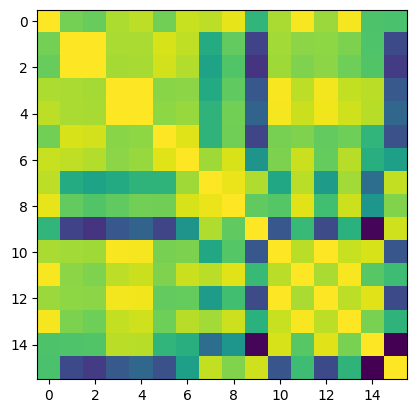

In [103]:
# Parameter correlation matrix.
# dist_autocorr = np.zeros((dist_ar.shape[0], dist_ar.shape[0]))
# for i in range(dist_ar.shape[0]):
#     for j in range(dist_ar.shape[1]):
#         dist_autocorr[i,j] =
        
dist_corr = np.corrcoef(dist_ar)

plt.imshow(dist_corr)